In [1]:
from __future__ import print_function, division
%matplotlib notebook

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from IPython.core.debugger import set_trace
import itertools
import seaborn as sns
from tqdm import tqdm
import random
import cv2
from natsort import natsorted
plt.ion()

# Check cuda.is_available ?

In [2]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("cuda_available : {}, device : {}".format(cuda_available, device))

cuda_available : True, device : cuda:0


# Define Dataset & DataLoader

In [3]:
MAXLEN = 300
FPS = 24.0

def drop_huge_seq(input_df, save_path="./preprocess/example_data/person_detection_and_tracking_results_drop.pkl"):
    if os.path.exists(save_path):
        print('Already dropped! Return...')
        return
    
    vids = list(set(input_df.vids))

    for i in tqdm(range(len(vids)), desc='DropInputSeq '):
        slice_df = input_df.loc[input_df.vids==vids[i]]
        if slice_df.values.shape[0] > MAXLEN:
            input_df.iloc[slice_df.index] = np.nan * np.ones_like(slice_df.values)

    # drop Nans !
    res_df = input_df.dropna()
    res_df.to_pickle("./preprocess/example_data/person_detection_and_tracking_results_drop.pkl")

input_df = pd.read_csv('./preprocess/example_data/person_detection_and_tracking_results.csv',
                       sep='\t', names=['vids', 'idx', 'pos'])
    
# drop huge seq
drop_huge_seq(input_df, save_path="./preprocess/example_data/person_detection_and_tracking_results_drop.pkl")

Already dropped! Return...


In [4]:
class GAITDataset(Dataset):
    def __init__(self, frame_home, input_file, target_file, phase, split_ratio, maxlen=300, r_seed=3):
        input_df = pd.read_pickle(input_file)
        target_df = pd.read_pickle(target_file)
        self.maxlen = maxlen
        self.frame_home = frame_home
        
        vids = list(set(input_df.vids))
        
        # reindex tgt data
        pids = []
        for vid in vids:
            split = os.path.splitext(vid)[0].split('_')
            pid = '_'.join([split[0], split[2], split[4]])
            pids.append(pid)
            
        self.input_df = input_df
        self.target_df = target_df.reindex(pids, fill_value=0.0)
        
        random.seed(r_seed)
        random.shuffle(vids)  # shuffle vids inplace, before datasplit

        if phase=='train':
            self.vids = vids[:int(len(vids)*split_ratio)]
        elif phase=='test':
            self.vids = vids[-int(len(vids)*split_ratio):]
            
    def __len__(self):
        return len(self.vids)
    
    def __getitem__(self, idx):
        vid = self.vids[idx]
        positions = [ eval(val) for val in self.input_df.loc[self.input_df.vids==vid].pos.values ]
        
        frame_dir = os.path.join(self.frame_home, vid)
        
        inputs = []
        for img_file in natsorted(os.listdir(frame_dir)):
            p = os.path.join(frame_dir, img_file)
            img_arr = cv2.imread(p)
            inputs.append(cv2.resize(img_arr, (112,112)))
            
        pid, _, test_ix, _, trial_ix, *_ = os.path.splitext(vid)[0].split('_')
        
        target_id = '_'.join([pid, test_ix, trial_ix])
        target_data = self.target_df.loc[target_id].values
        
        # parse target data
        targets, (start, end) = target_data[:-2], target_data[-2:]
        
        # zero padding
        inputs = np.pad(inputs, ((0,self.maxlen-len(inputs)),(0,0),(0,0),(0,0)),
                                               'constant', constant_values=0).transpose(3,1,2,0)
        
        sample = {'inputs': torch.tensor(inputs, dtype=torch.float32),
                  'targets': torch.tensor(targets, dtype=torch.float32)}
        
        return sample





In [14]:
# dataset path
input_file = "./preprocess/example_data/person_detection_and_tracking_results_drop.pkl"
target_file = "./preprocess/data/targets_dataframe.pkl"
frame_home = "/data/GaitData/CroppedFrames"


dataset = { phase : GAITDataset(frame_home, input_file, target_file, phase=phase, split_ratio=split_ratio) \
                for phase,split_ratio in zip(['train', 'test'], [0.8, 0.2]) }
dataloader = { phase : DataLoader(dataset[phase],
                        batch_size=5,
                        shuffle=True,
                        num_workers=16) \
                    for phase in ['train', 'test'] }

# Define DNN

In [15]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)

class GAP(nn.Module):
    def __init__(self):
        super(GAP, self).__init__()
    def forward(self, x):
        '''
        
            x : size = (N,C,D,H,W)
        '''
        return torch.mean(x, (2,3,4))
        
        
class Net(nn.Module):
    def __init__(self, input_channel, target_size):
        super(Net, self).__init__()
                
        self.model = nn.Sequential(nn.Conv3d(input_channel, 64, kernel_size=7, stride=2),
                                   nn.BatchNorm3d(64), 
                                   nn.ReLU(),
                                   nn.MaxPool3d(kernel_size=(3,), stride=2),
                                   nn.Conv3d(64, 128, kernel_size=3, stride=2),
                                   nn.BatchNorm3d(128), 
                                   nn.ReLU(),
                                   nn.MaxPool3d(kernel_size=(3,), stride=2),
                                   GAP(),
                                   nn.Linear(128, target_size)
                                  )
        

    def forward(self, x):
        '''
            x : size = (batch, input_size, maxlen)
        '''
        return self.model(x)        
        
net = Net(input_channel=3,
          target_size=len(dataset['train'].target_df.columns)-2)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)
else:
    print("Single GPU mode")

net.to(device)

Let's use 4 GPUs!


DataParallel(
  (module): Net(
    (model): Sequential(
      (0): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=(3,), stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2))
      (5): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=(3,), stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): GAP()
      (9): Linear(in_features=128, out_features=17, bias=True)
    )
  )
)

# Define criterion

In [16]:
# define criterion
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()

def Normal(x, mu=0.0, sigma=1.0):
    if type(x)==torch.Tensor:
        x = x.detach().cpu().numpy()
        
    res = (1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )).astype(np.float32)
    return torch.tensor(res).float().to(device)


df_list = []  # list of df to merge

for phase in ['train', 'test']:
    df_list.append(
        dataset[phase].target_df.iloc[:,:-2]
    )

df = pd.concat(df_list)  #  concat

# mean and std from data
mu = df.values.mean(0)
sigma = df.values.std(0)

# criterion = lambda x, y, alpha : torch.mean( alpha * torch.pow( (x - y), 2) )
criterion = lambda x, y : torch.mean( torch.pow(1-Normal(x, mu, sigma), 2) * torch.pow( (x - y), 2) )
# criterion = lambda x, y : torch.mean( torch.abs(torch.log( 1. / (Normal(x, mu, sigma)+1e-7) )) * torch.pow( (x - y), 2) )
# criterion = lambda x, y : torch.mean( 
#     torch.tanh( torch.abs(torch.log( 1. / (Normal(x, mu, sigma)) )) ) * torch.pow( (x - y), 2) )

# Training Loop

In [21]:
# cost history saving..
history = {'train': [],
           'test': []}

import torch.optim as optim
from torch.optim import lr_scheduler

# Observe that all parameters are being optimized
# optimizer = optim.Adam(net.parameters(), lr=1e-3)
# optimizer = optim.RMSprop(net.parameters(), lr=1e-2)
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

epoch_loss = {'train': 0.0, 'test': 0.0}
pred_and_gt = { k:[] for k in df.columns.values }

end_epoch = 1

print("Start training loop...")

for epoch in range(1,end_epoch+1):        
    for phase in ['train', 'test']:
        if phase=='train':
            net.train()
        elif phase=='test':
            net.eval()
        
        running_loss = 0.0

        for idx, batch_item in enumerate(dataloader[phase]):
            inputs, targets = batch_item['inputs'].to(device), batch_item['targets'].to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase=='train'):
                # feed data to network
                res = net(inputs)
                # compute loss                
                loss = criterion(res, targets)
                print(loss.item())
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                                    
                if epoch==end_epoch and phase=='test':
                    for i,col in enumerate(df.columns.values):
                        pred_and_gt[col].append([res[:,i].detach().cpu().numpy(), targets[:,i].cpu().numpy()])
                        
            running_loss += loss.item() * len(inputs)
            
            
        avg_loss = running_loss / len(dataloader[phase].dataset)
                
        epoch_loss[phase] += avg_loss
        
        if epoch % 5 == 0:
            print('=================={}========================'.format(phase.upper()))
            print('EPOCH : {}, WEIGHTED_SQUARED_ERROR (WSE) : {:.4f}'.format(epoch, epoch_loss[phase] / 5))
            history[phase].append(epoch_loss[phase] / 5)
            
            # init epoch_loss at its own phase
            epoch_loss[phase] = 0.0

print("Done!!")

Start training loop...
92.48389434814453
51.586761474609375
95.92919158935547
73.29912567138672
59.58477783203125
56.76393127441406
152.73841857910156
88.13777923583984
144.8423309326172
118.38971710205078
Done!!


<IPython.core.display.Javascript object>


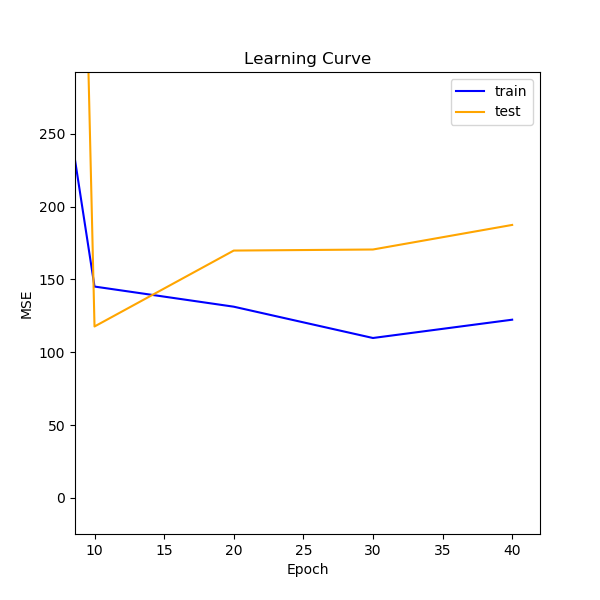

Saving learning curve...


In [18]:
# plot learning curve
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(np.arange(len(history['train'])*10, step=10), history['train'], label='train', color='b')
ax.plot(np.arange(len(history['test'])*10, step=10), history['test'], label='test', color='orange')

ax.set_title('Learning Curve')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
plt.legend()

print("Saving learning curve...")
fig.savefig('learning.png', dpi=fig.dpi)

<IPython.core.display.Javascript object>


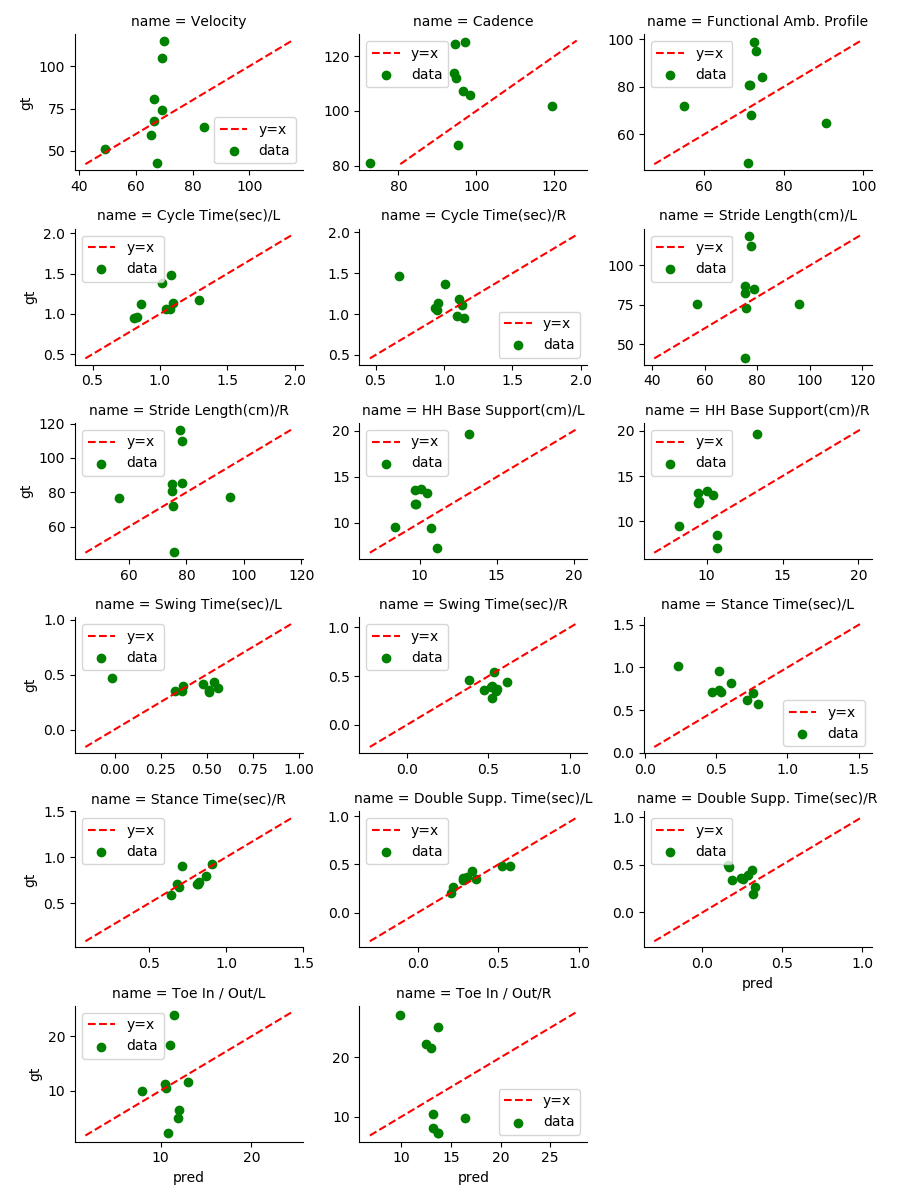

Traceback (most recent call last):
  File "/home/hossay/anaconda3/envs/torch/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/hossay/anaconda3/envs/torch/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/hossay/anaconda3/envs/torch/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/hossay/anaconda3/envs/torch/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/hossay/anaconda3/envs/torch/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/hossay/anaconda3/envs/torch/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/hossay/anaconda3/envs/torch/lib/

In [22]:
import collections


data = collections.defaultdict(list)

pp = []
gg = []
for i,col in enumerate(pred_and_gt.keys()):
    transposed_data = list(zip(*pred_and_gt[col]))
    preds = np.concatenate(transposed_data[0])
    gts = np.concatenate(transposed_data[1])
    
    pp.append(preds)
    gg.append(gts)
    
    for p,g in zip(preds, gts):
        data["name"].append(col)
        data["pred"].append(p)
        data["gt"].append(g)
        
df = pd.DataFrame(data)

grid = sns.FacetGrid(df, col="name", col_wrap=3, height=2, aspect=1.5, sharex=False, sharey=False)
grid.map(plt.scatter, "pred", "gt", color='g', label='data')

for i,(preds,gts) in enumerate(zip(pp,gg)):
    grid.axes[i].plot([min(gts)-0.5, max(gts)+0.5], [min(gts)-0.5, max(gts)+0.5], 'r--', label='y=x')
    grid.axes[i].legend()